# HumpBack Whale Identification 
### Image classification competition from Kaggle

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader,Dataset

import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
train_df.describe()

,Image,Id
count,25361,25361
unique,25361,5005
top,49bf4801c.jpg,new_whale
freq,1,9664


In [4]:
import os
from PIL import Image

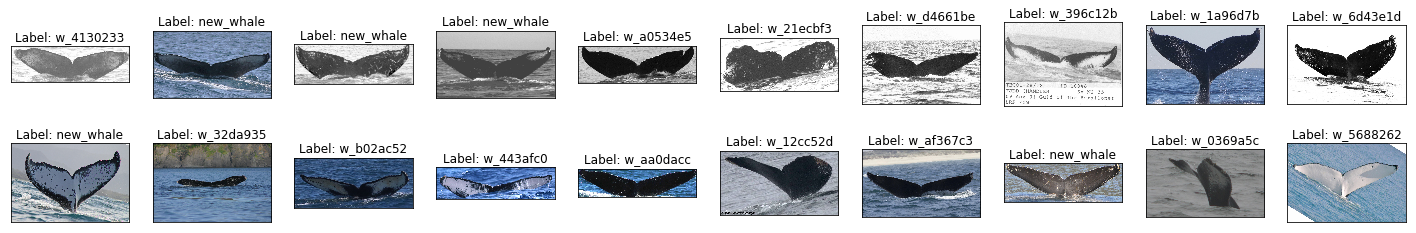

In [5]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("train/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("train/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [6]:

data_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((128, 128)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])



In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [8]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [9]:
y, le = prepare_labels(train_df['Id'])

G:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
class WhaleDataset(Dataset):
    # From here : https://www.kaggle.com/artgor/pytorch-whale-identifier
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [11]:
train_dataset = WhaleDataset(datafolder='train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='test/', datatype='test', transform=data_transforms_test)

In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.20 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size= 256,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 128,sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_set, batch_size = 32)

In [13]:
dataiter = iter(trainloader)
image, label = dataiter.next()
image = image.numpy()
print(image.shape)

(256, 3, 128, 128)


In [14]:
from torch import nn

In [15]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        # sees 128 X 128 X 3
        self.conv1 = nn.Conv2d(3, 16, 3, padding= 1)
        # sees 64 X 64 X 16
        self.conv2 = nn.Conv2d(16, 32, 3, padding= 1)
        #sees 32 X 32 X 32
        self.conv3 = nn.Conv2d(32, 64, 3, padding= 1)
        #sees 16 X 16 x 64
        self.conv4 = nn.Conv2d(64, 128, 3, padding= 1)
        #sees 8 X 8 X 128
        self.conv5 = nn.Conv2d(128, 256, 3, padding= 1)
        
        self.pool = nn.MaxPool2d(2,2)
        # sees 4 X 4 X 256
        self.fc1 = nn.Linear(4 * 4 * 256, 1024)
        self.out = nn.Linear(1024, 5005)
        
        self.drop = nn.Dropout(0.25)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 256*4*4)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.log_softmax(self.out(x), dim= 1)
        return x

model = net()
model
model.to('cuda')
            

net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=5005, bias=True)
  (drop): Dropout(p=0.25)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.01)

In [18]:
epoch  = 50
train_losses, valid_losses = [], []
for e in range(epoch):
    trainloss = 0
    validloss = 0
    model.train()
    for images, labels in trainloader:
        images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        trainloss += loss.item() * images.size(0)
    else:
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to('cuda'), labels.to('cuda')
                output = model(images)
                loss = criterion(output, torch.max(labels, 1)[1])
                validloss += loss.item() * images.size(0)
        trainloss = trainloss/ len(trainloader.dataset)
        validloss = validloss/len(valid_loader.dataset)
        train_losses.append(trainloss)
        valid_losses.append(validloss)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e, trainloss, validloss))
    

Epoch: 0 	Training Loss: 5.871714 	Validation Loss: 1.219768
Epoch: 1 	Training Loss: 4.983901 	Validation Loss: 1.208168
Epoch: 2 	Training Loss: 4.905216 	Validation Loss: 1.188821
Epoch: 3 	Training Loss: 4.815364 	Validation Loss: 1.201586
Epoch: 4 	Training Loss: 4.757140 	Validation Loss: 1.177227
Epoch: 5 	Training Loss: 4.713931 	Validation Loss: 1.169527
Epoch: 6 	Training Loss: 4.670102 	Validation Loss: 1.168349
Epoch: 7 	Training Loss: 4.664153 	Validation Loss: 1.160291
Epoch: 8 	Training Loss: 4.619901 	Validation Loss: 1.159658
Epoch: 9 	Training Loss: 4.615586 	Validation Loss: 1.159018
Epoch: 10 	Training Loss: 4.606727 	Validation Loss: 1.154560
Epoch: 11 	Training Loss: 4.594447 	Validation Loss: 1.157071
Epoch: 12 	Training Loss: 4.577163 	Validation Loss: 1.153422
Epoch: 13 	Training Loss: 4.559532 	Validation Loss: 1.152058
Epoch: 14 	Training Loss: 4.568062 	Validation Loss: 1.152464
Epoch: 15 	Training Loss: 4.541651 	Validation Loss: 1.150358
Epoch: 16 	Trainin

In [20]:
sub = pd.read_csv('sample_submission.csv')

model.eval()
for (data, target, name) in testloader:
    data = data.cuda()
    output = model(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)